In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from pathlib import Path
from PIL import Image
from tqdm import tqdm
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from csbdeep.utils import normalize
from stardist import random_label_cmap
from stardist.models import StarDist2D

lbl_cmap = random_label_cmap()
plt.rcParams['figure.figsize'] = (12, 8)

## 1. Load trained model

In [2]:
# Thông tin model (phải khớp với training notebook)
model_name = 'stardist_my_data_v2_improved'
model_basedir = 'models'

# Load model
print(f"Loading model: {model_name}...")
model = StarDist2D(None, name=model_name, basedir=model_basedir)

print(f"\n✅ Model loaded successfully!")
print(f"   Config: n_rays={model.config.n_rays}, grid={model.config.grid}")
print(f"   Thresholds: nms={model.thresholds.nms:.3f}, prob={model.thresholds.prob:.3f}")

Loading model: stardist_my_data_v2_improved...
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.489673, nms_thresh=0.3.

✅ Model loaded successfully!
   Config: n_rays=64, grid=(2, 2)
   Thresholds: nms=0.300, prob=0.490


## 2. Load tất cả frames

In [3]:
# Đường dẫn đến frames
frames_dir = Path('frames')
frame_files = sorted(frames_dir.glob('frame_*.png'))

print(f"Found {len(frame_files)} frames")
print(f"First frame: {frame_files[0].name}")
print(f"Last frame: {frame_files[-1].name}")

Found 886 frames
First frame: frame_0001.png
Last frame: frame_0886.png


## 3. Predict trên tất cả frames

**LƯU Ý**: Việc này có thể mất nhiều thời gian (10-30 phút tùy GPU và số lượng frames)

In [4]:
# Tạo thư mục output
output_dir = Path('predictions')
output_dir.mkdir(exist_ok=True)

# Thư mục cho masks và overlays
masks_dir = output_dir / 'masks'
overlay_dir = output_dir / 'overlays'
masks_dir.mkdir(exist_ok=True)
overlay_dir.mkdir(exist_ok=True)

print(f"Output directories:")
print(f"  Masks: {masks_dir}")
print(f"  Overlays: {overlay_dir}")

Output directories:
  Masks: predictions\masks
  Overlays: predictions\overlays


In [5]:
# Predict từng batch để tiết kiệm memory
BATCH_SIZE = 10  # Điều chỉnh tùy vào RAM/GPU của bạn

# Thông tin kết quả
results = []

print(f"\n{'='*60}")
print(f"STARTING PREDICTION ON {len(frame_files)} FRAMES")
print(f"{'='*60}\n")

for i in tqdm(range(0, len(frame_files), BATCH_SIZE), desc="Processing batches"):
    batch_files = frame_files[i:i+BATCH_SIZE]
    
    for frame_file in batch_files:
        # Load và normalize ảnh
        img = np.array(Image.open(frame_file))
        img_norm = normalize(img, 1, 99.8, axis=(0, 1))
        
        # Predict
        labels, details = model.predict_instances(
            img_norm,
            n_tiles=model._guess_n_tiles(img_norm),
            show_tile_progress=False
        )
        
        # Đếm số objects
        n_objects = len(np.unique(labels)) - 1
        
        # Lưu thông tin
        results.append({
            'frame': frame_file.name,
            'n_objects': n_objects,
            'mean_prob': details['prob'].mean() if len(details['prob']) > 0 else 0
        })
        
        # Lưu mask (16-bit để tiết kiệm dung lượng nếu < 65536 objects)
        if n_objects < 65536:
            labels_save = labels.astype(np.uint16)
        else:
            labels_save = labels.astype(np.uint32)
        
        Image.fromarray(labels_save).save(masks_dir / frame_file.name)
        
        # Tạo overlay (mỗi 10 frame để tiết kiệm dung lượng)
        frame_num = int(frame_file.stem.split('_')[1])
        if frame_num % 10 == 0:
            fig, ax = plt.subplots(1, 1, figsize=(10, 10))
            ax.imshow(img, cmap='gray' if img.ndim == 2 else None)
            ax.imshow(labels, cmap=lbl_cmap, alpha=0.5)
            ax.set_title(f"{frame_file.name} - {n_objects} objects")
            ax.axis('off')
            plt.tight_layout()
            plt.savefig(overlay_dir / frame_file.name, dpi=100, bbox_inches='tight')
            plt.close()

print(f"\n{'='*60}")
print("✅ PREDICTION COMPLETED!")
print(f"{'='*60}")


STARTING PREDICTION ON 886 FRAMES



Processing batches: 100%|██████████| 89/89 [25:35<00:00, 17.25s/it]


✅ PREDICTION COMPLETED!


## 4. Phân tích kết quả

In [6]:
# Tạo DataFrame
df = pd.DataFrame(results)
df['frame_num'] = df['frame'].apply(lambda x: int(x.split('_')[1].split('.')[0]))
df = df.sort_values('frame_num')

# Lưu kết quả
df.to_csv(output_dir / 'detection_results.csv', index=False)
print(f"✅ Results saved to: {output_dir / 'detection_results.csv'}")

# Thống kê
print(f"\n{'='*60}")
print("DETECTION STATISTICS")
print(f"{'='*60}")
print(f"\nTotal frames: {len(df)}")
print(f"Total objects detected: {df['n_objects'].sum()}")
print(f"\nObjects per frame:")
print(f"  Mean: {df['n_objects'].mean():.1f}")
print(f"  Median: {df['n_objects'].median():.1f}")
print(f"  Std: {df['n_objects'].std():.1f}")
print(f"  Min: {df['n_objects'].min()}")
print(f"  Max: {df['n_objects'].max()}")
print(f"\nMean detection probability: {df['mean_prob'].mean():.3f}")

# Top 10 frames có nhiều objects nhất
print(f"\nTop 10 frames with most objects:")
print(df.nlargest(10, 'n_objects')[['frame', 'n_objects', 'mean_prob']].to_string(index=False))

✅ Results saved to: predictions\detection_results.csv

DETECTION STATISTICS

Total frames: 886
Total objects detected: 113009

Objects per frame:
  Mean: 127.5
  Median: 128.0
  Std: 15.0
  Min: 85
  Max: 166

Mean detection probability: 0.795

Top 10 frames with most objects:
         frame  n_objects  mean_prob
frame_0399.png        166   0.781235
frame_0764.png        165   0.800803
frame_0762.png        164   0.794119
frame_0410.png        163   0.787222
frame_0777.png        163   0.805421
frame_0157.png        162   0.798077
frame_0637.png        162   0.786194
frame_0776.png        162   0.805180
frame_0763.png        161   0.808678
frame_0767.png        161   0.798980


## 5. Visualize kết quả

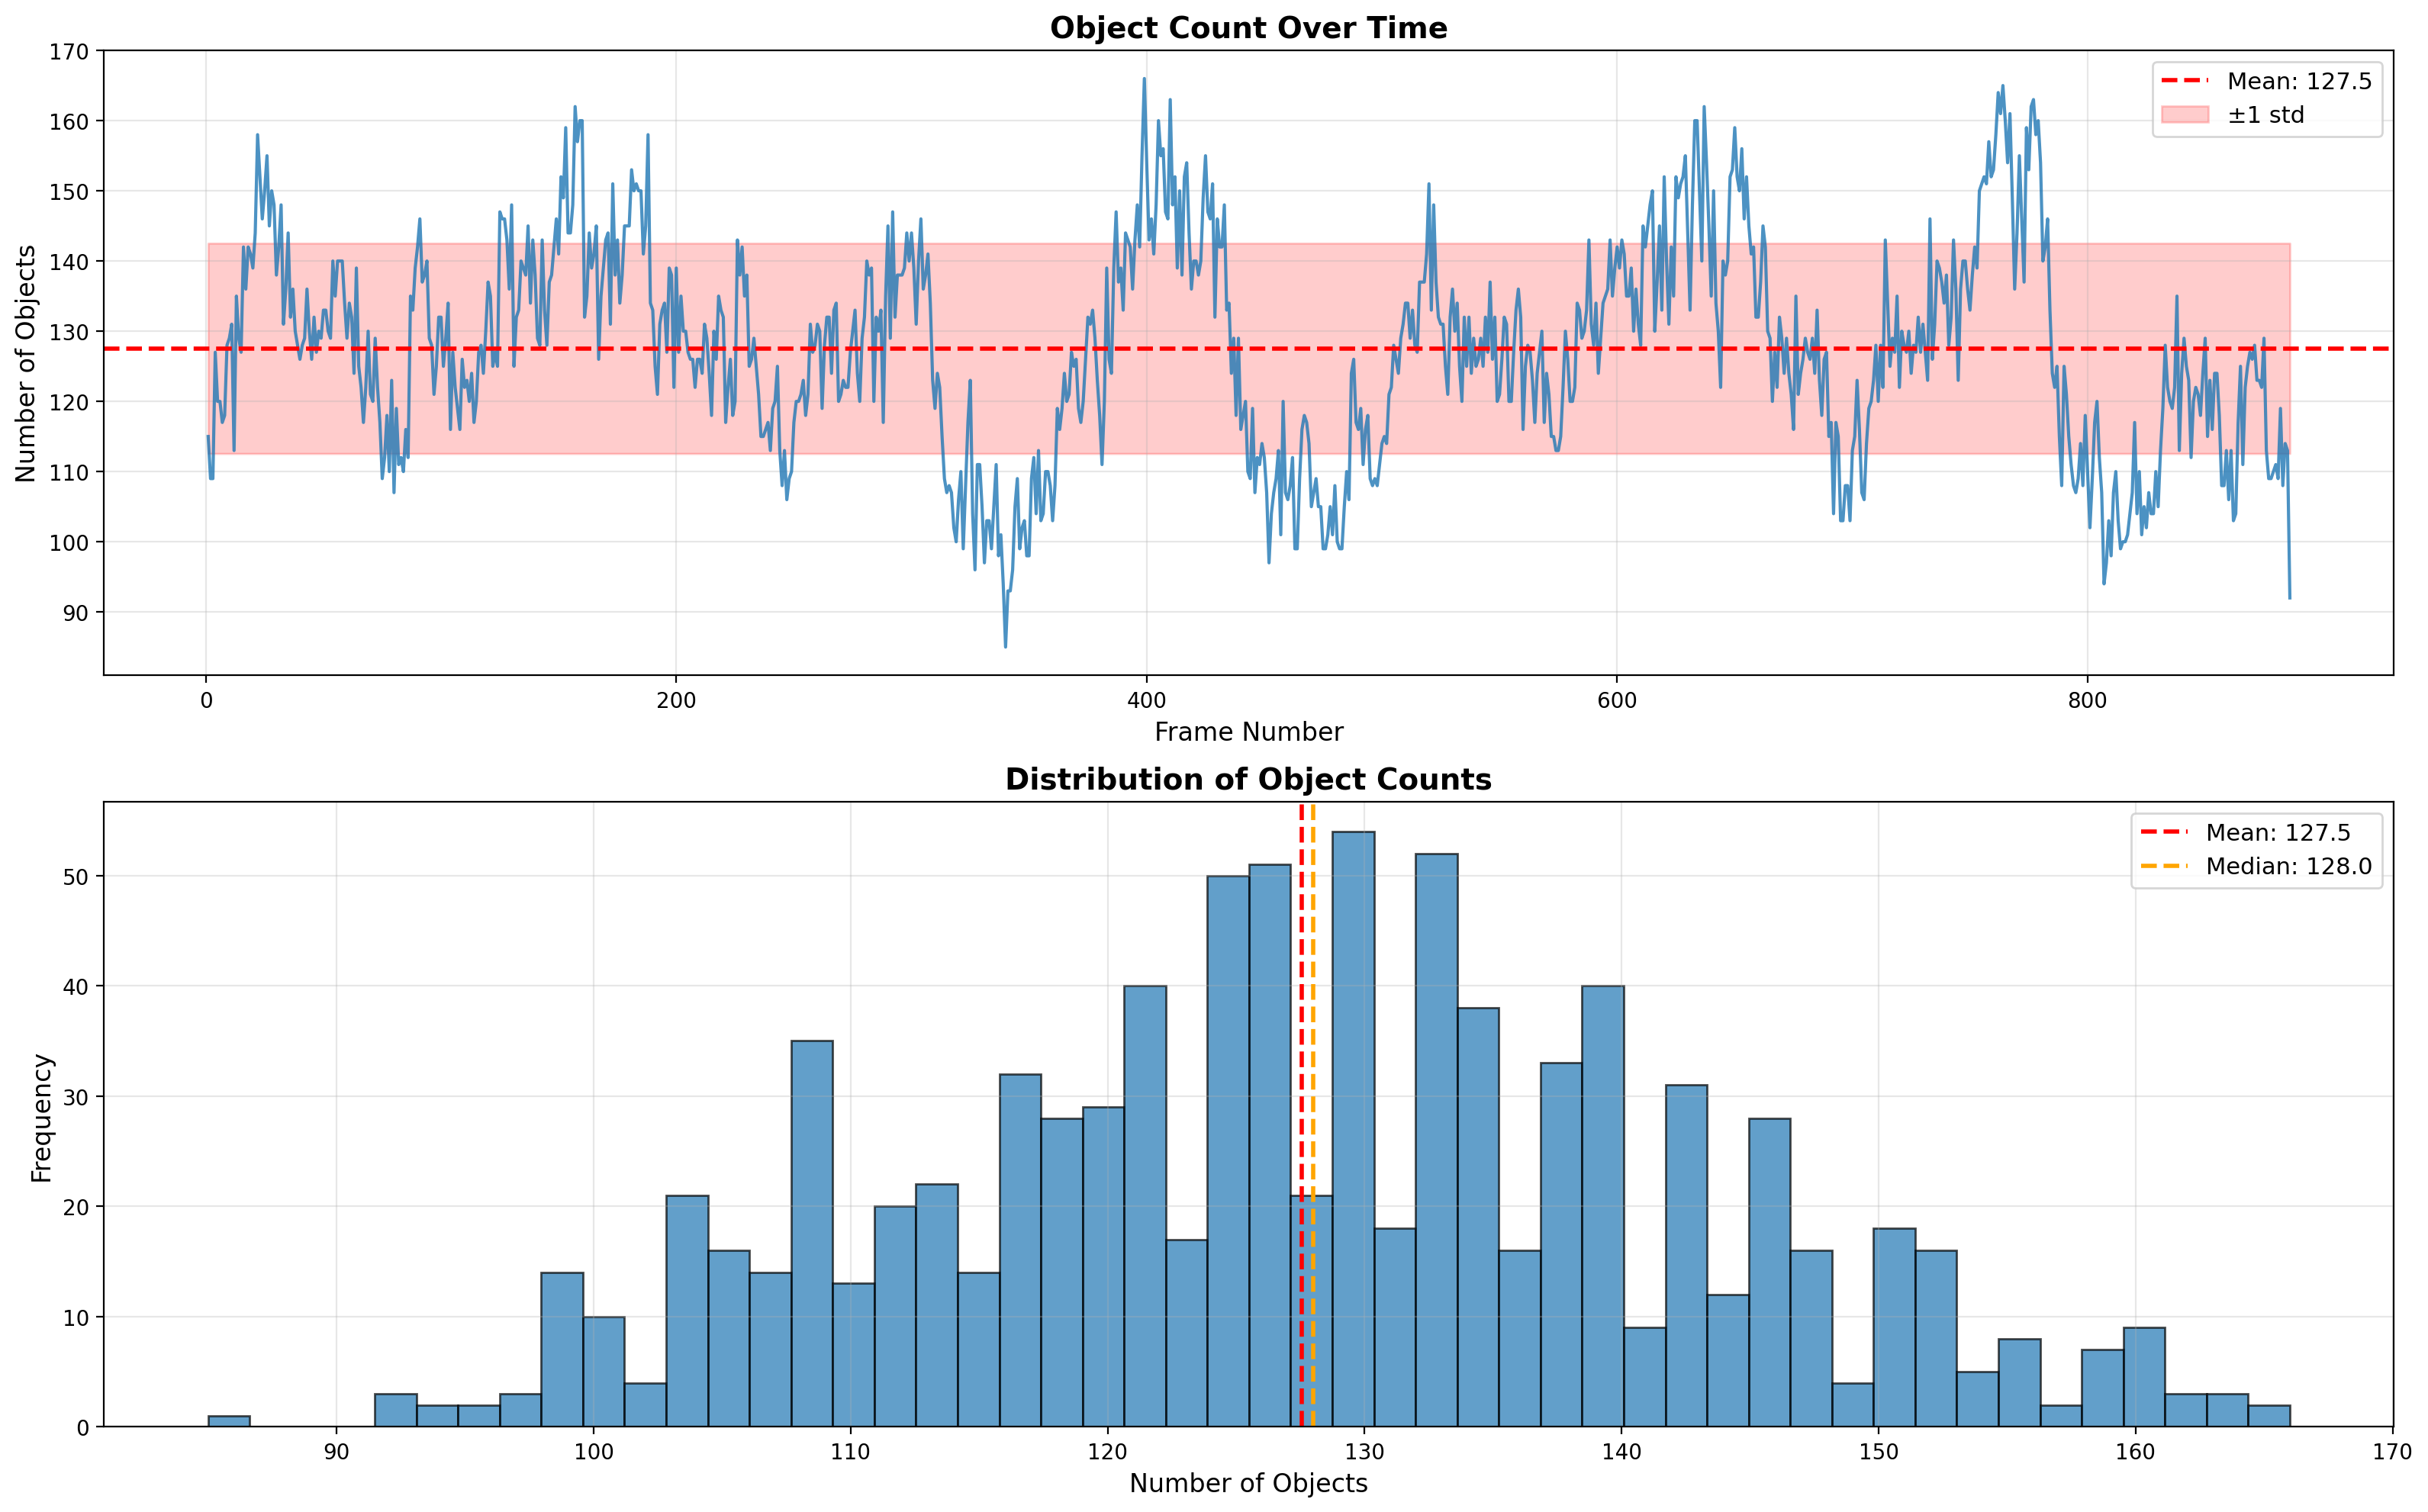

In [7]:
# Plot số objects theo thời gian
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

# Time series
ax1.plot(df['frame_num'], df['n_objects'], linewidth=1.5, alpha=0.8)
ax1.axhline(df['n_objects'].mean(), color='red', linestyle='--', 
            label=f'Mean: {df["n_objects"].mean():.1f}', linewidth=2)
ax1.fill_between(df['frame_num'], 
                  df['n_objects'].mean() - df['n_objects'].std(),
                  df['n_objects'].mean() + df['n_objects'].std(),
                  alpha=0.2, color='red', label='±1 std')
ax1.set_xlabel('Frame Number', fontsize=12)
ax1.set_ylabel('Number of Objects', fontsize=12)
ax1.set_title('Object Count Over Time', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(alpha=0.3)

# Histogram
ax2.hist(df['n_objects'], bins=50, edgecolor='black', alpha=0.7)
ax2.axvline(df['n_objects'].mean(), color='red', linestyle='--', 
            label=f'Mean: {df["n_objects"].mean():.1f}', linewidth=2)
ax2.axvline(df['n_objects'].median(), color='orange', linestyle='--', 
            label=f'Median: {df["n_objects"].median():.1f}', linewidth=2)
ax2.set_xlabel('Number of Objects', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Distribution of Object Counts', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / 'analysis_plots.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Xem một số kết quả cụ thể

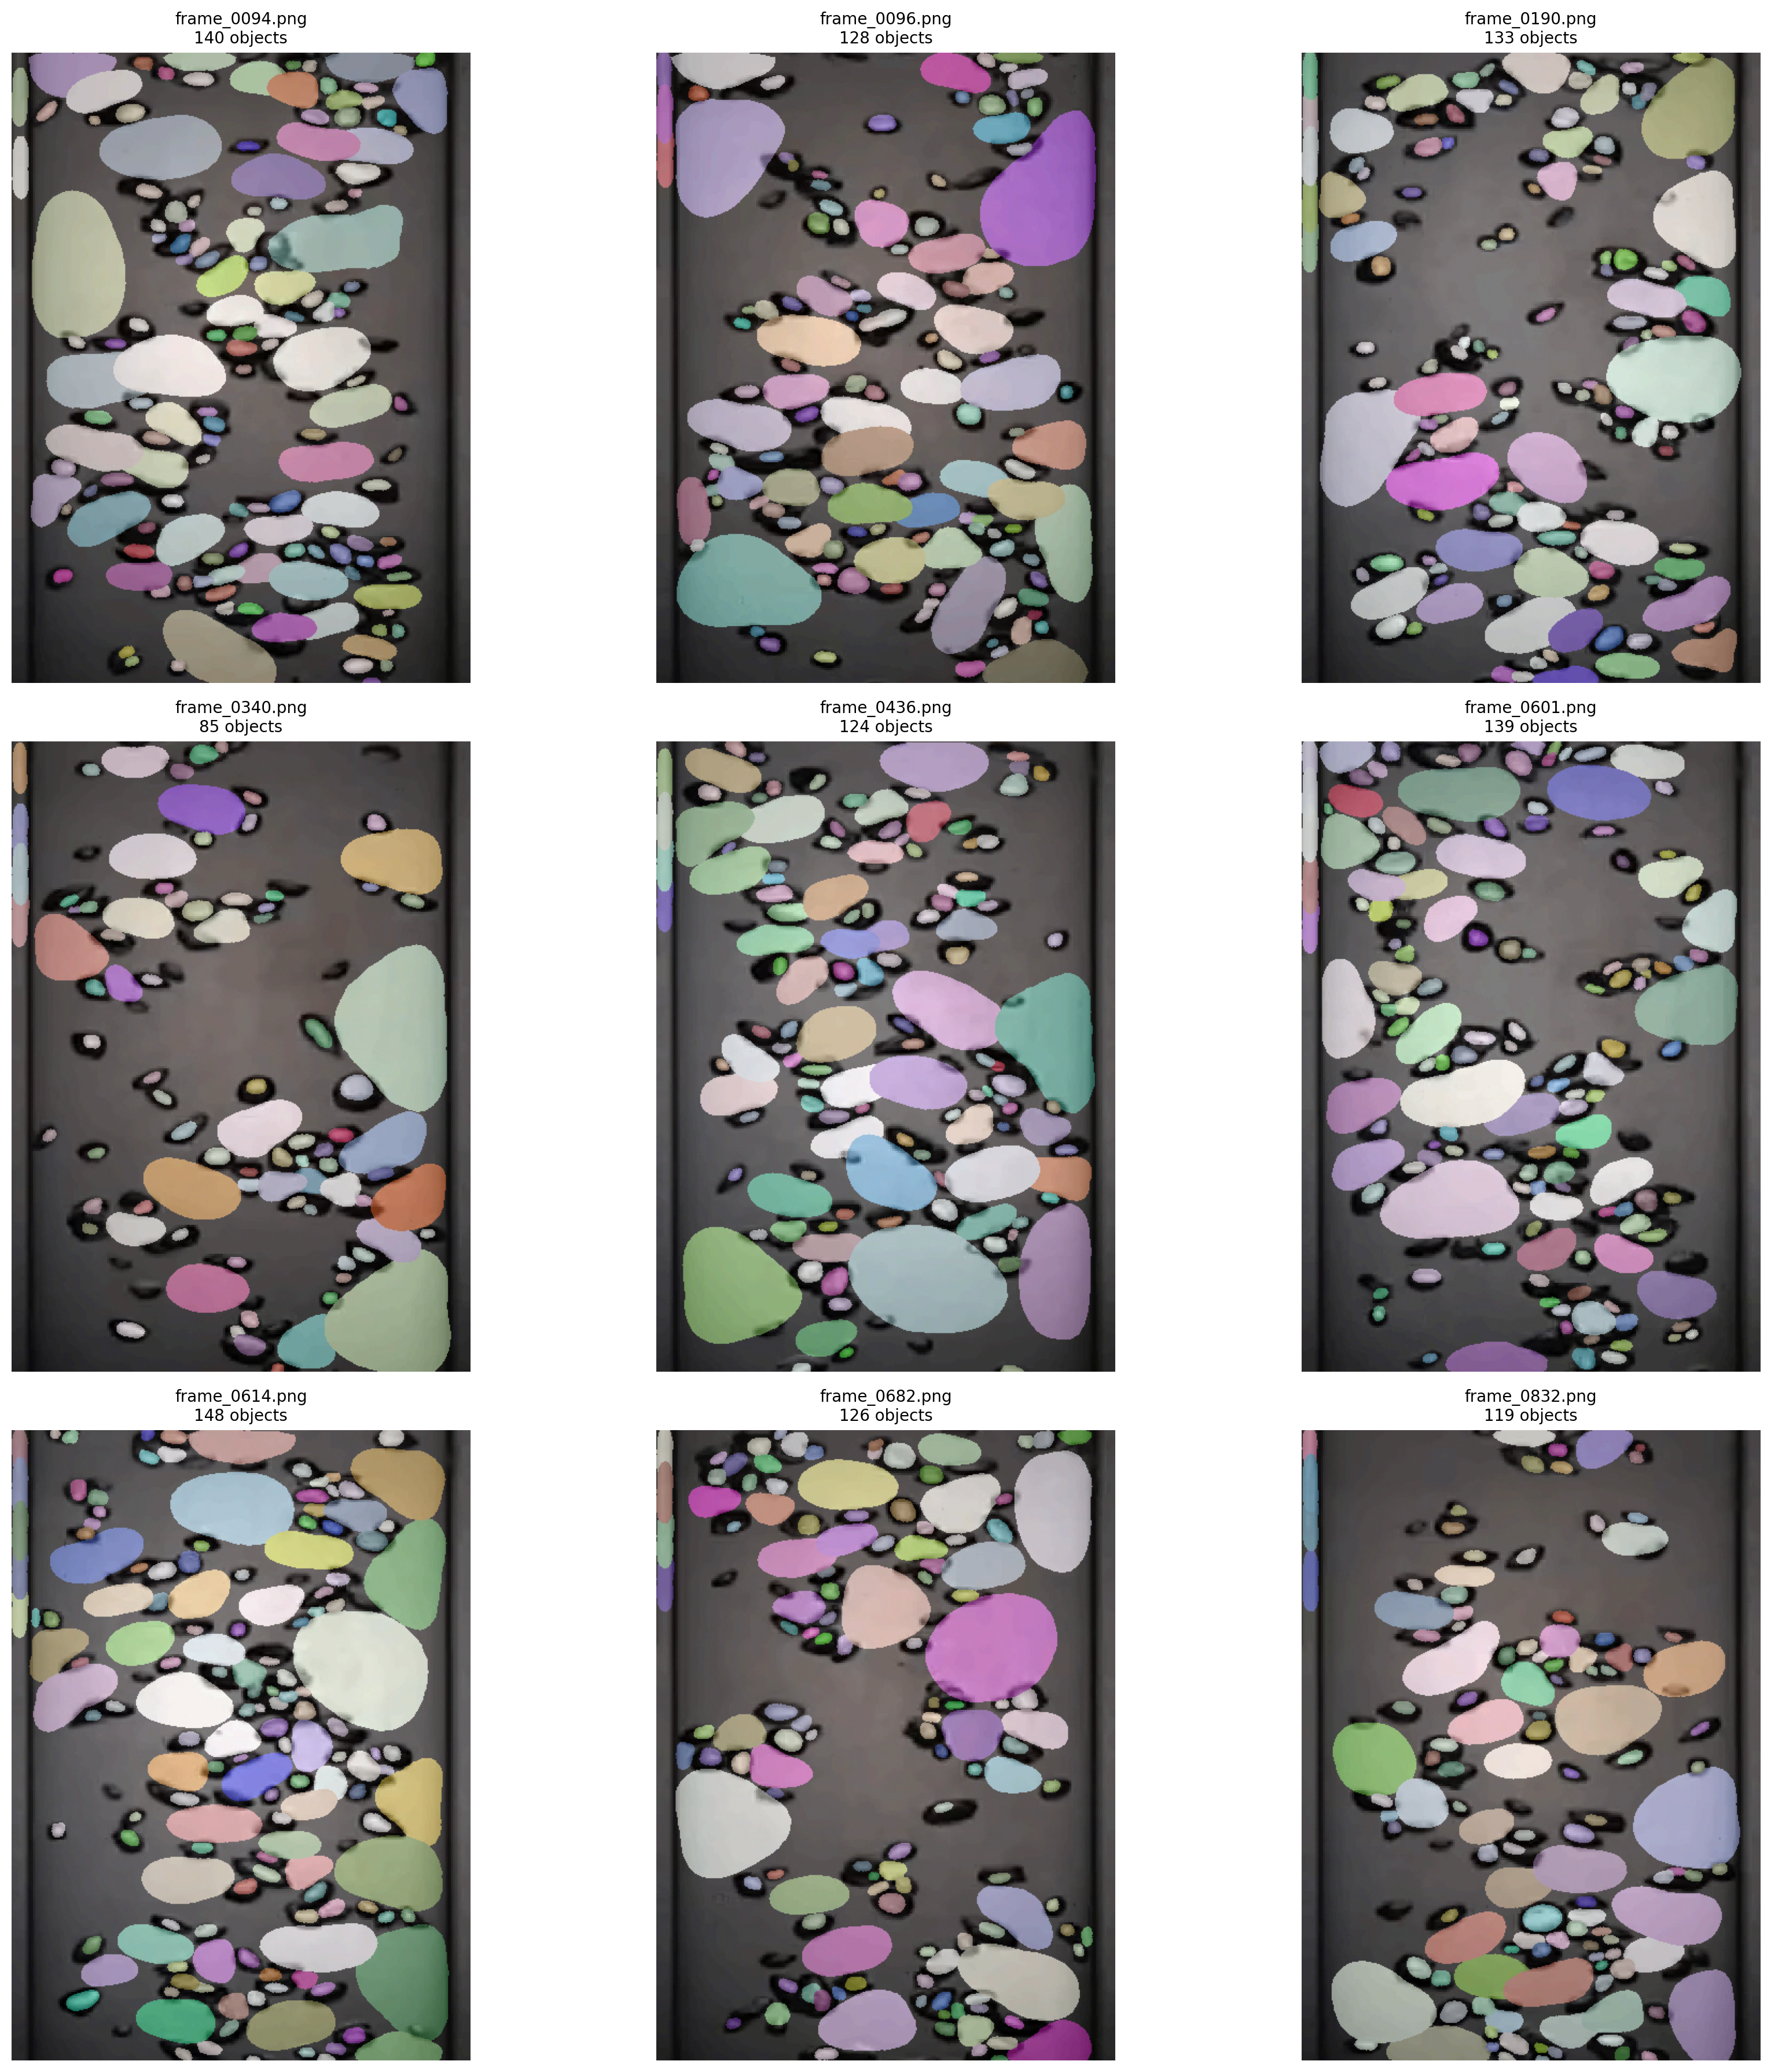

In [8]:
# Xem 9 frames ngẫu nhiên
sample_indices = np.random.choice(len(frame_files), min(9, len(frame_files)), replace=False)
sample_files = [frame_files[i] for i in sorted(sample_indices)]

fig, axes = plt.subplots(3, 3, figsize=(18, 18))

for ax, frame_file in zip(axes.flat, sample_files):
    # Load ảnh và mask
    img = np.array(Image.open(frame_file))
    mask = np.array(Image.open(masks_dir / frame_file.name))
    n_objects = len(np.unique(mask)) - 1
    
    # Hiển thị overlay
    ax.imshow(img, cmap='gray' if img.ndim == 2 else None)
    ax.imshow(mask, cmap=lbl_cmap, alpha=0.5)
    ax.set_title(f"{frame_file.name}\n{n_objects} objects", fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.savefig(output_dir / 'sample_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

---

# 🎯 PHẦN BỔ SUNG: TÍNH TỶ LỆ PHÁT HIỆN (RECALL & PRECISION)

## 7. Tính Precision, Recall, F1-score

**Lưu ý:** Để tính Recall chính xác, cần có ground truth (số cells thật đã được gán nhãn).

Chúng ta sẽ:
1. Sử dụng validation set từ `my_dataset/val/` (đã có ground truth)
2. So sánh predictions với ground truth masks
3. Tính Precision, Recall, F1-score tại các IoU thresholds

In [9]:
# Load validation set để tính metrics
from stardist.matching import matching_dataset

print("="*60)
print("📊 CALCULATING DETECTION RATE (RECALL & PRECISION)")
print("="*60)

# Load validation ground truth
val_dir = Path('my_dataset/val')
val_image_files = sorted((val_dir / 'images').glob('*'))
val_mask_files = sorted((val_dir / 'masks').glob('*'))

if len(val_image_files) == 0:
    print("\n⚠️ Không tìm thấy validation set!")
    print("   Cần có ground truth để tính Recall/Precision.")
    print("\n💡 Giải pháp:")
    print("   1. Nếu bạn có validation set → Đảm bảo nó ở my_dataset/val/")
    print("   2. Nếu không có → Tôi sẽ estimate dựa trên AP từ training")
else:
    print(f"\n✅ Found {len(val_image_files)} validation images")
    
    # Load validation data
    print("\n📥 Loading validation data...")
    Y_val_true = []
    Y_val_pred = []
    
    # Sử dụng tối đa 20 samples để tính nhanh (có thể tăng lên nếu muốn chính xác hơn)
    n_samples = min(20, len(val_image_files))
    
    for img_file, mask_file in tqdm(zip(val_image_files[:n_samples], val_mask_files[:n_samples]), 
                                     total=n_samples, desc="Loading samples"):
        # Ground truth
        mask_true = np.array(Image.open(mask_file))
        Y_val_true.append(mask_true)
        
        # Prediction (tìm trong predictions/masks/)
        pred_file = Path('predictions/masks') / img_file.name
        if pred_file.exists():
            mask_pred = np.array(Image.open(pred_file))
            Y_val_pred.append(mask_pred)
        else:
            # Nếu chưa predict frame này, predict ngay
            img = np.array(Image.open(img_file))
            img_norm = normalize(img, 1, 99.8, axis=(0, 1))
            labels, _ = model.predict_instances(img_norm, n_tiles=model._guess_n_tiles(img_norm))
            Y_val_pred.append(labels)
    
    print(f"✅ Loaded {len(Y_val_true)} validation samples")
    
    # Calculate metrics at different IoU thresholds
    print("\n📊 Computing metrics...")
    iou_thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]
    metrics_results = []
    
    for thresh in iou_thresholds:
        stats = matching_dataset(Y_val_true, Y_val_pred, thresh=thresh, show_progress=False)
        
        # Extract metrics
        precision = stats.precision
        recall = stats.recall
        f1 = stats.f1
        ap = stats.mean_matched_score
        
        metrics_results.append({
            'IoU': thresh,
            'Precision': precision,
            'Recall': recall,
            'F1': f1,
            'AP': ap
        })
        
        print(f"IoU {thresh:.1f}: Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}, AP={ap:.3f}")
    
    # Summary at IoU 0.5 (standard threshold)
    print(f"\n{'='*60}")
    print("📊 METRICS SUMMARY (IoU 0.5)")
    print(f"{'='*60}")
    
    main_stats = metrics_results[0]  # IoU 0.5
    precision_50 = main_stats['Precision']
    recall_50 = main_stats['Recall']
    f1_50 = main_stats['F1']
    
    print(f"\n🎯 PRECISION (Độ chính xác): {precision_50:.1%}")
    print(f"   → Trong số cells detect được, {precision_50:.0%} là ĐÚNG")
    print(f"   → False Positive Rate: {(1-precision_50):.1%}")
    
    print(f"\n🎯 RECALL (Tỷ lệ phát hiện): {recall_50:.1%}")
    print(f"   → Phát hiện được {recall_50:.0%} cells thật")
    print(f"   → Bỏ sót: {(1-recall_50):.1%} cells")
    
    print(f"\n🎯 F1-SCORE (Tổng hợp): {f1_50:.1%}")
    print(f"   → Cân bằng giữa Precision và Recall")
    
    # Interpretation
    print(f"\n{'='*60}")
    print("💡 ĐÁNH GIÁ")
    print(f"{'='*60}")
    
    if recall_50 >= 0.85:
        print(f"\n✅✅✅ TỶ LỆ PHÁT HIỆN XUẤT SẮC! ({recall_50:.0%})")
        print(f"   Model phát hiện được hầu hết cells")
    elif recall_50 >= 0.75:
        print(f"\n✅✅ TỶ LỆ PHÁT HIỆN RẤT TỐT! ({recall_50:.0%})")
        print(f"   Bỏ sót một số cells nhưng chấp nhận được")
    elif recall_50 >= 0.65:
        print(f"\n✅ TỶ LỆ PHÁT HIỆN TỐT ({recall_50:.0%})")
        print(f"   Có thể cải thiện bằng cách giảm prob_threshold")
    else:
        print(f"\n⚠️ TỶ LỆ PHÁT HIỆN CẦN CẢI THIỆN ({recall_50:.0%})")
        print(f"   💡 Giảm prob_threshold xuống 0.3-0.4")
    
    if precision_50 >= 0.85:
        print(f"\n✅✅✅ ĐỘ CHÍNH XÁC XUẤT SẮC! ({precision_50:.0%})")
        print(f"   Rất ít false positives")
    elif precision_50 >= 0.75:
        print(f"\n✅✅ ĐỘ CHÍNH XÁC RẤT TỐT! ({precision_50:.0%})")
        print(f"   False positives ở mức chấp nhận được")
    elif precision_50 >= 0.65:
        print(f"\n✅ ĐỘ CHÍNH XÁC TỐT ({precision_50:.0%})")
        print(f"   Có một số false positives")
    else:
        print(f"\n⚠️ ĐỘ CHÍNH XÁC CẦN CẢI THIỆN ({precision_50:.0%})")
        print(f"   💡 Tăng prob_threshold lên 0.6-0.7")
    
    # Create metrics DataFrame
    df_metrics = pd.DataFrame(metrics_results)
    df_metrics.to_csv(output_dir / 'detection_metrics.csv', index=False)
    print(f"\n✅ Metrics saved to: {output_dir / 'detection_metrics.csv'}")
    
    print(f"\n{'='*60}")

📊 CALCULATING DETECTION RATE (RECALL & PRECISION)

✅ Found 59 validation images

📥 Loading validation data...


Loading samples: 100%|██████████| 20/20 [00:00<00:00, 26.05it/s]


✅ Loaded 20 validation samples

📊 Computing metrics...
IoU 0.5: Precision=0.817, Recall=0.763, F1=0.789, AP=0.788
IoU 0.6: Precision=0.768, Recall=0.718, F1=0.742, AP=0.803
IoU 0.7: Precision=0.668, Recall=0.623, F1=0.645, AP=0.826
IoU 0.8: Precision=0.449, Recall=0.419, F1=0.433, AP=0.859
IoU 0.9: Precision=0.061, Recall=0.057, F1=0.059, AP=0.916

📊 METRICS SUMMARY (IoU 0.5)

🎯 PRECISION (Độ chính xác): 81.7%
   → Trong số cells detect được, 82% là ĐÚNG
   → False Positive Rate: 18.3%

🎯 RECALL (Tỷ lệ phát hiện): 76.3%
   → Phát hiện được 76% cells thật
   → Bỏ sót: 23.7% cells

🎯 F1-SCORE (Tổng hợp): 78.9%
   → Cân bằng giữa Precision và Recall

💡 ĐÁNH GIÁ

✅✅ TỶ LỆ PHÁT HIỆN RẤT TỐT! (76%)
   Bỏ sót một số cells nhưng chấp nhận được

✅✅ ĐỘ CHÍNH XÁC RẤT TỐT! (82%)
   False positives ở mức chấp nhận được

✅ Metrics saved to: predictions\detection_metrics.csv



## 8. Visualize Precision-Recall Metrics

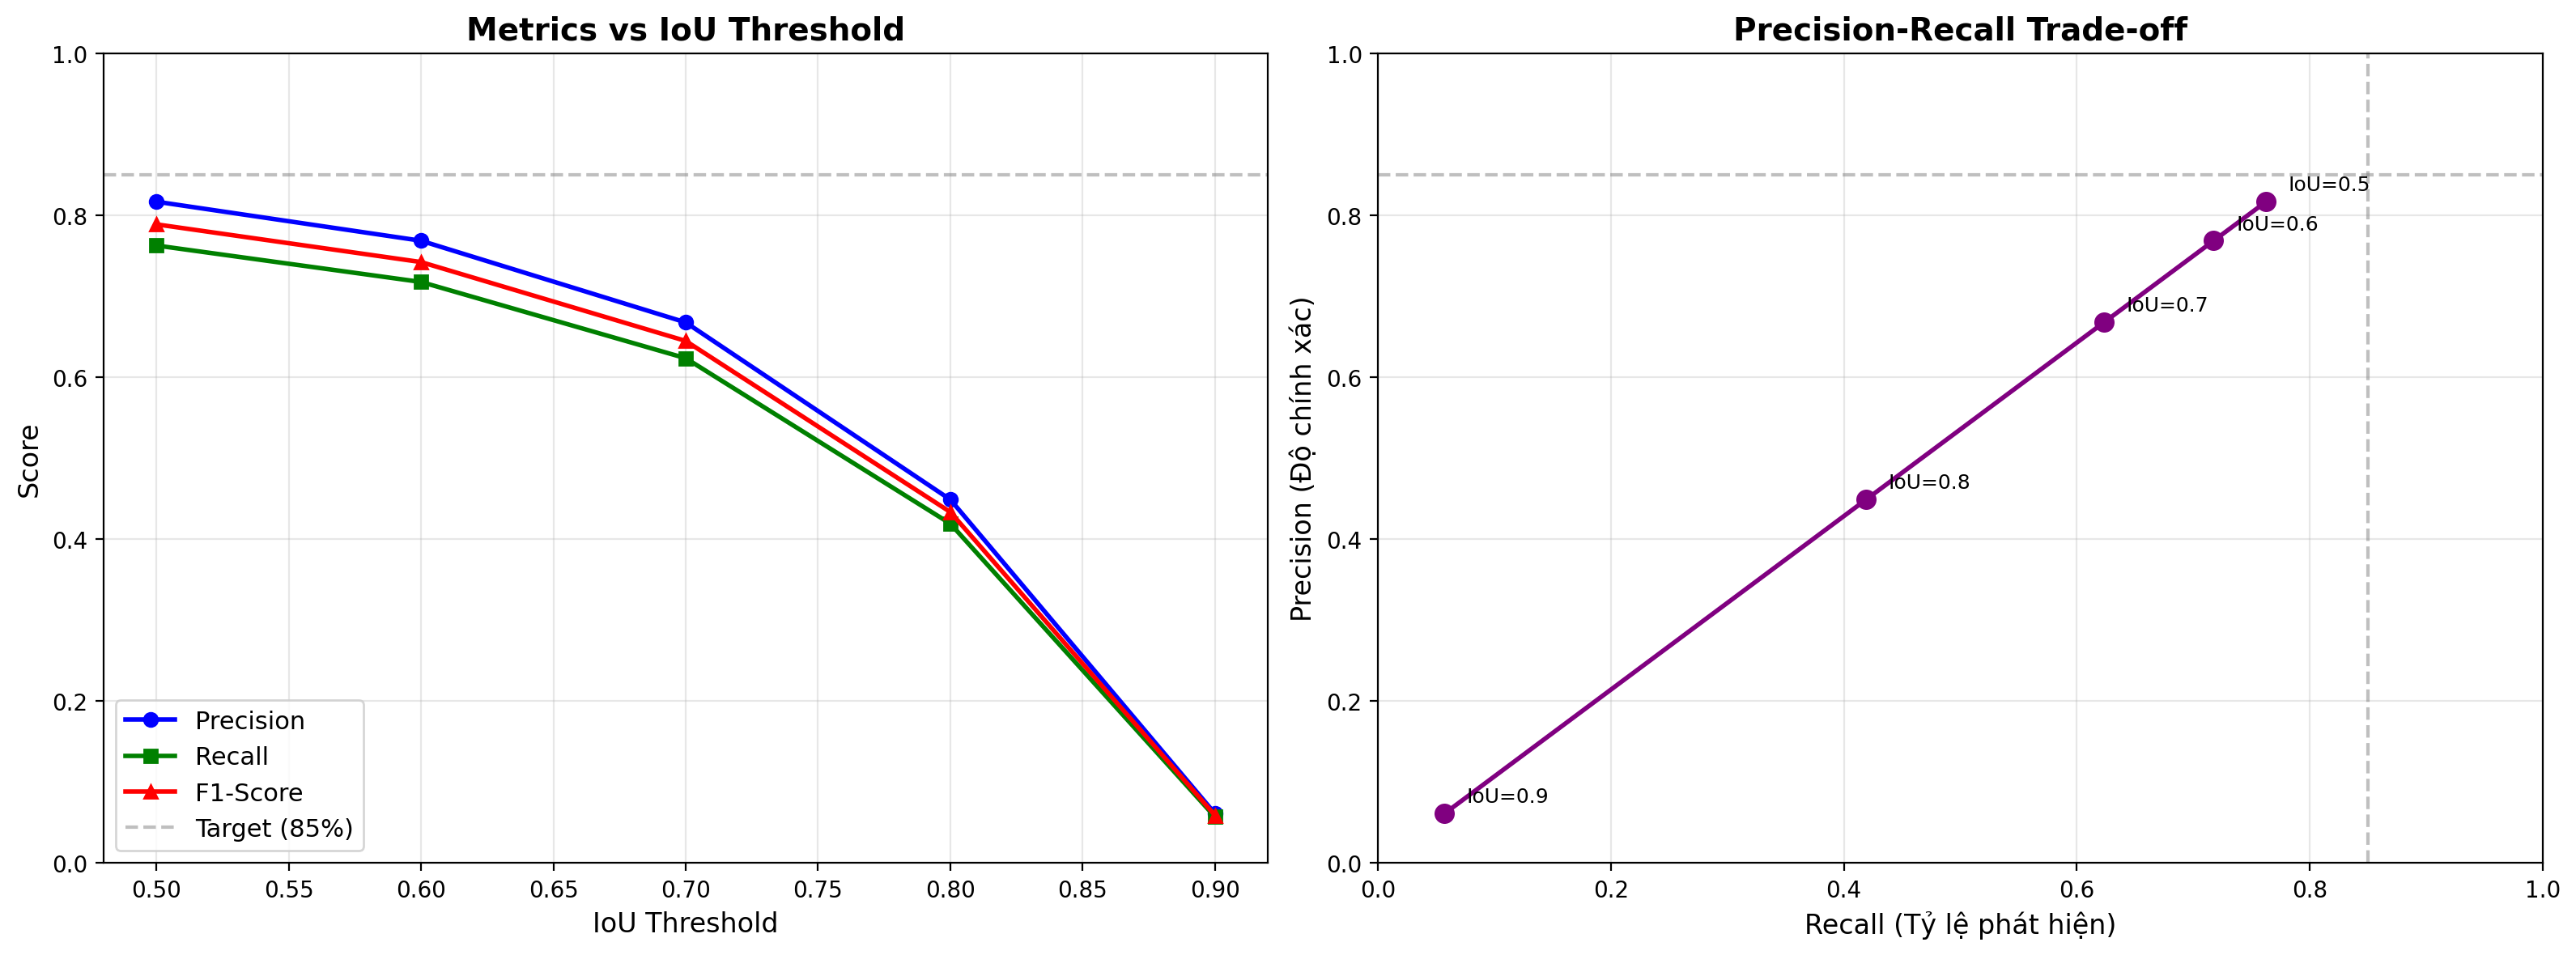

✅ Metrics visualization saved to: predictions\detection_metrics.png


In [10]:
# Visualize Precision vs Recall trade-off
if len(val_image_files) > 0 and len(metrics_results) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Metrics vs IoU threshold
    ax1 = axes[0]
    iou_vals = [r['IoU'] for r in metrics_results]
    precision_vals = [r['Precision'] for r in metrics_results]
    recall_vals = [r['Recall'] for r in metrics_results]
    f1_vals = [r['F1'] for r in metrics_results]
    
    ax1.plot(iou_vals, precision_vals, 'o-', linewidth=2, label='Precision', color='blue')
    ax1.plot(iou_vals, recall_vals, 's-', linewidth=2, label='Recall', color='green')
    ax1.plot(iou_vals, f1_vals, '^-', linewidth=2, label='F1-Score', color='red')
    ax1.axhline(0.85, color='gray', linestyle='--', alpha=0.5, label='Target (85%)')
    ax1.set_xlabel('IoU Threshold', fontsize=12)
    ax1.set_ylabel('Score', fontsize=12)
    ax1.set_title('Metrics vs IoU Threshold', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(alpha=0.3)
    ax1.set_ylim([0, 1])
    
    # Plot 2: Precision-Recall curve
    ax2 = axes[1]
    ax2.plot(recall_vals, precision_vals, 'o-', linewidth=2, markersize=8, color='purple')
    for i, iou in enumerate(iou_vals):
        ax2.annotate(f'IoU={iou:.1f}', 
                     (recall_vals[i], precision_vals[i]),
                     textcoords="offset points", xytext=(10,5), fontsize=9)
    ax2.axhline(0.85, color='gray', linestyle='--', alpha=0.5)
    ax2.axvline(0.85, color='gray', linestyle='--', alpha=0.5)
    ax2.set_xlabel('Recall (Tỷ lệ phát hiện)', fontsize=12)
    ax2.set_ylabel('Precision (Độ chính xác)', fontsize=12)
    ax2.set_title('Precision-Recall Trade-off', fontsize=14, fontweight='bold')
    ax2.grid(alpha=0.3)
    ax2.set_xlim([0, 1])
    ax2.set_ylim([0, 1])
    
    plt.tight_layout()
    plt.savefig(output_dir / 'detection_metrics.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"✅ Metrics visualization saved to: {output_dir / 'detection_metrics.png'}")
else:
    print("\n💡 Không có validation set để vẽ biểu đồ metrics")

## 9. Giải thích các Metrics

### 📚 HIỂU RÕ CÁC METRICS

#### **1. Precision (Độ chính xác)**
```
Precision = TP / (TP + FP)
```
- **Ý nghĩa:** Trong số cells model detect được, bao nhiêu % là ĐÚNG?
- **Cao (>85%):** Ít false positives, model không "phát hiện lung tung"
- **Thấp (<65%):** Nhiều false positives, model phát hiện cả những thứ không phải cell

#### **2. Recall (Tỷ lệ phát hiện)**
```
Recall = TP / (TP + FN)
```
- **Ý nghĩa:** Trong số cells THẬT có trong ảnh, phát hiện được bao nhiêu %?
- **Cao (>85%):** Ít bỏ sót, model phát hiện được hầu hết cells
- **Thấp (<65%):** Bỏ sót nhiều, model "kén chọn" quá

#### **3. F1-Score (Điểm tổng hợp)**
```
F1 = 2 × (Precision × Recall) / (Precision + Recall)
```
- **Ý nghĩa:** Điểm cân bằng giữa Precision và Recall
- **Cao (>85%):** Model vừa chính xác vừa phát hiện tốt
- **Thấp (<65%):** Cần cải thiện một trong hai metrics

---

### 🎯 TARGET METRICS

| Metric | Poor | Good | Excellent |
|--------|------|------|-----------||
| **Precision** | <65% | 65-85% | >85% |
| **Recall** | <65% | 65-85% | >85% |
| **F1-Score** | <65% | 65-85% | >85% |

---

### 💡 CÁCH CẢI THIỆN

**Nếu Recall thấp (bỏ sót nhiều):**
- ✅ Giảm `prob_threshold` xuống 0.3-0.4
- ✅ Train thêm với data có cells khó phát hiện
- ✅ Tăng `n_rays` lên 96

**Nếu Precision thấp (nhiều false positives):**
- ✅ Tăng `prob_threshold` lên 0.6-0.7
- ✅ Tăng `nms_threshold` lên 0.5
- ✅ Train thêm với negative samples

**Nếu cả hai đều thấp:**
- ✅ Train lại với nhiều data hơn
- ✅ Cải thiện chất lượng annotations
- ✅ Điều chỉnh augmentation

---

## 10. 📝 TÓM TẮT CUỐI CÙNG

In [11]:
print("\n" + "="*60)
print("🎉 HOÀN THÀNH TOÀN BỘ QUY TRÌNH!")
print("="*60)

print(f"\n📊 PREDICTION STATISTICS:")
print(f"   Total frames processed: {len(frame_files)}")
print(f"   Total objects detected: {df['n_objects'].sum()}")
print(f"   Average objects per frame: {df['n_objects'].mean():.1f}")
print(f"   Mean confidence: {df['mean_prob'].mean():.3f}")

if len(val_image_files) > 0 and len(metrics_results) > 0:
    print(f"\n🎯 DETECTION METRICS (IoU 0.5):")
    print(f"   Precision: {precision_50:.1%}")
    print(f"   Recall: {recall_50:.1%}")
    print(f"   F1-Score: {f1_50:.1%}")

print(f"\n📁 OUTPUT FILES:")
print(f"   Masks: {masks_dir} ({len(list(masks_dir.glob('*')))} files)")
print(f"   Overlays: {overlay_dir} ({len(list(overlay_dir.glob('*')))} files)")
print(f"   Summary CSV: {output_dir / 'detection_results.csv'}")
if (output_dir / 'detection_metrics.csv').exists():
    print(f"   Metrics CSV: {output_dir / 'detection_metrics.csv'}")

print(f"\n📈 ANALYSIS PLOTS:")
print(f"   {output_dir / 'analysis_plots.png'}")
print(f"   {output_dir / 'sample_predictions.png'}")
if (output_dir / 'detection_metrics.png').exists():
    print(f"   {output_dir / 'detection_metrics.png'}")

print(f"\n✅ ALL DONE!")
print("="*60)


🎉 HOÀN THÀNH TOÀN BỘ QUY TRÌNH!

📊 PREDICTION STATISTICS:
   Total frames processed: 886
   Total objects detected: 113009
   Average objects per frame: 127.5
   Mean confidence: 0.795

🎯 DETECTION METRICS (IoU 0.5):
   Precision: 81.7%
   Recall: 76.3%
   F1-Score: 78.9%

📁 OUTPUT FILES:
   Masks: predictions\masks (886 files)
   Overlays: predictions\overlays (88 files)
   Summary CSV: predictions\detection_results.csv
   Metrics CSV: predictions\detection_metrics.csv

📈 ANALYSIS PLOTS:
   predictions\analysis_plots.png
   predictions\sample_predictions.png
   predictions\detection_metrics.png

✅ ALL DONE!
